In [1]:
import requests
from bs4 import BeautifulSoup
import spotipy
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import pickle
import random

In [2]:
#Spotify credentials

client_id=''
client_secret=''

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id,client_secret))

In [3]:
# Import CSV with song_ids into a Dataframe.

df = pd.read_csv('song_id_extraction_v3.csv')

In [4]:
df

,song_id
0,001McWPVLHQbQzDVq2Ndiq
1,003vvx7Niy0yvhvHt4a68B
2,0071kWo4vzvKWe6dsxKeWj
3,00B7SBwrjbycLMOgAmeIU8
4,00CqEmnPLFKDhAb3cuu6Cs
...,...
20143,7zvYcp4GcbqkXWCL03pkO8
20144,7zwwvrJAWGjfc9wFD3bVzZ
20145,7zxUQuM8AKfuXLatnmWuWm
20146,7zxa7uJdNakO0braiv8jdx


In [5]:
# Get the features for each song

song_ids = df['song_id'].tolist()

song_features = []
batch_size = 100 

for i in range(0, len(song_ids), batch_size):
    batch_song_ids = song_ids[i:i+batch_size]
    batch_features = sp.audio_features(batch_song_ids)


    if batch_features is not None:
        valid_features = [feat for feat in batch_features if feat is not None]
        song_features.extend(valid_features)

    time.sleep(0.1) 

df_features = pd.DataFrame(song_features)

In [6]:
df_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.154,0.735,0,-12.889,1,0.0573,0.44100,0.07020,0.6450,0.398,133.746,audio_features,001McWPVLHQbQzDVq2Ndiq,spotify:track:001McWPVLHQbQzDVq2Ndiq,https://api.spotify.com/v1/tracks/001McWPVLHQb...,https://api.spotify.com/v1/audio-analysis/001M...,79672,4
1,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.00000,0.0995,0.236,148.033,audio_features,003vvx7Niy0yvhvHt4a68B,spotify:track:003vvx7Niy0yvhvHt4a68B,https://api.spotify.com/v1/tracks/003vvx7Niy0y...,https://api.spotify.com/v1/audio-analysis/003v...,222973,4
2,0.259,0.985,1,-2.383,1,0.1720,0.01180,0.00000,0.2670,0.497,177.056,audio_features,0071kWo4vzvKWe6dsxKeWj,spotify:track:0071kWo4vzvKWe6dsxKeWj,https://api.spotify.com/v1/tracks/0071kWo4vzvK...,https://api.spotify.com/v1/audio-analysis/0071...,134853,4
3,0.663,0.710,11,-5.550,0,0.0599,0.00745,0.00559,0.1470,0.487,120.984,audio_features,00B7SBwrjbycLMOgAmeIU8,spotify:track:00B7SBwrjbycLMOgAmeIU8,https://api.spotify.com/v1/tracks/00B7SBwrjbyc...,https://api.spotify.com/v1/audio-analysis/00B7...,251589,4
4,0.575,0.985,2,-1.038,0,0.0743,0.04000,0.00000,0.1610,0.477,116.006,audio_features,00CqEmnPLFKDhAb3cuu6Cs,spotify:track:00CqEmnPLFKDhAb3cuu6Cs,https://api.spotify.com/v1/tracks/00CqEmnPLFKD...,https://api.spotify.com/v1/audio-analysis/00Cq...,177960,4


In [7]:
len(song_ids)

20148

In [8]:
df_features = df_features.drop(['type','uri', 'track_href', 'analysis_url'], axis=1)

In [9]:
df_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.154,0.735,0,-12.889,1,0.0573,0.44100,0.07020,0.6450,0.398,133.746,001McWPVLHQbQzDVq2Ndiq,79672,4
1,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.00000,0.0995,0.236,148.033,003vvx7Niy0yvhvHt4a68B,222973,4
2,0.259,0.985,1,-2.383,1,0.1720,0.01180,0.00000,0.2670,0.497,177.056,0071kWo4vzvKWe6dsxKeWj,134853,4
3,0.663,0.710,11,-5.550,0,0.0599,0.00745,0.00559,0.1470,0.487,120.984,00B7SBwrjbycLMOgAmeIU8,251589,4
4,0.575,0.985,2,-1.038,0,0.0743,0.04000,0.00000,0.1610,0.477,116.006,00CqEmnPLFKDhAb3cuu6Cs,177960,4


In [10]:
#scaling the columns using StandardScaler
y = df_features['id']
x = df_features.drop(['id'], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-1.882213,-0.262434,-1.472985,-1.742414,0.619099,-0.265992,1.428799,-0.179561,0.889357,-0.205343,0.273791,-1.667325,0.185964
1,-0.604908,0.644240,-1.190012,0.499276,0.619099,-0.076871,-0.550029,-0.471600,-0.852039,-0.915668,0.758112,-0.240857,0.185964
2,-1.204854,1.025455,-1.190012,1.332556,0.619099,0.980688,-0.502380,-0.471600,-0.317330,0.228745,1.741973,-1.118034,0.185964
3,1.401365,-0.391223,1.639717,0.405616,-1.615249,-0.237733,-0.521952,-0.448345,-0.700405,0.184898,-0.158832,0.043997,0.185964
4,0.833673,1.025455,-0.907039,1.726220,-1.615249,-0.081218,-0.375494,-0.471600,-0.655713,0.141050,-0.327584,-0.688932,0.185964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20137,-1.933821,0.108478,1.073772,0.117319,0.619099,-0.229038,0.168943,-0.471473,1.237317,-0.591198,0.705025,0.387640,0.185964
20138,-0.295258,-0.561224,0.790799,-1.181040,0.619099,-0.523589,-0.554443,1.175796,-0.789790,-0.227266,1.964285,-0.765381,0.185964
20139,-0.411377,0.994546,-0.341093,0.764158,0.619099,0.148119,-0.555108,-0.471567,1.636354,0.211206,-0.684510,-0.734991,0.185964
20140,-0.572653,0.922424,-0.624066,0.420836,0.619099,-0.210560,-0.552733,-0.470431,-0.537598,-0.398271,1.500982,-0.192011,0.185964


In [11]:
# Save StandardScaler to pickle file

scaler_filename = 'scaler_sd.pkl'
pickle.dump(scaler, open(scaler_filename, 'wb'))

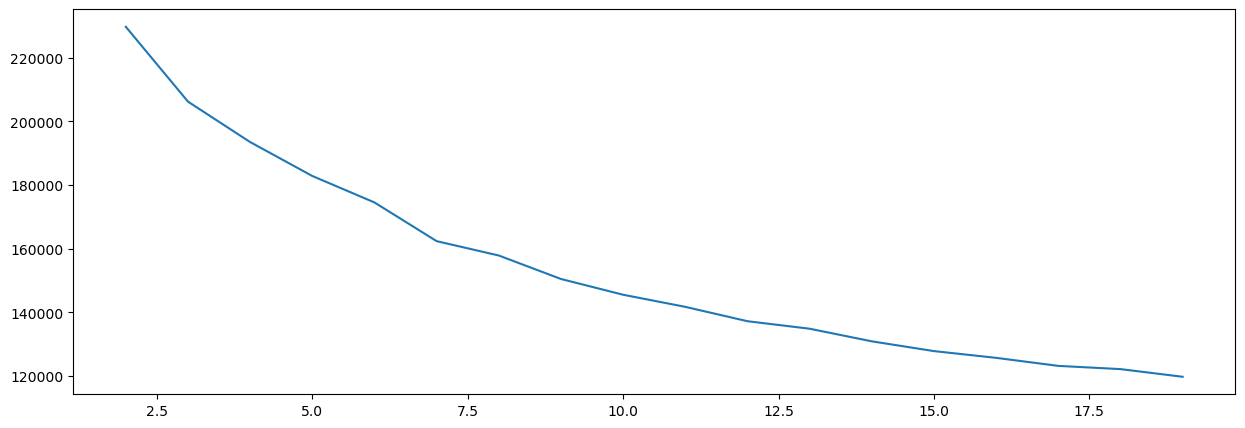

In [12]:
# Create KMEANS model - INERTIA

K = range(2, 20)
inertia_list = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
plt.figure(figsize=(15,5))
plt.plot(K, inertia_list)

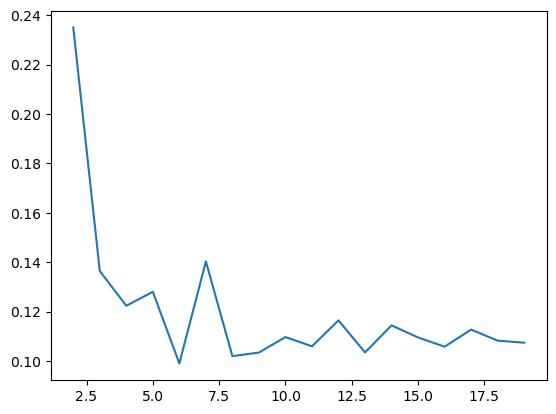

In [13]:
#Create KMEANS model - SILHOUETE SCORE
K = range(2,20)
silhouette_list = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X)
    silhouette_list.append(silhouette_score(X, kmeans.predict(X)))
    
plt.plot(K, silhouette_list)
plt.show()

In [14]:
# Run KMeans model
kmeans = KMeans(n_clusters= 7, random_state=1234)
kmeans.fit(X)
model_filename = 'kmeans.pkl'
pickle.dump(kmeans, open(model_filename, 'wb'))

In [15]:
#Adding a 'cluster' and 'id' column to my dataframe

clusters_kmeans = kmeans.predict(X)
X['cluster_KM'] = clusters_kmeans
X['id'] = y
X.to_csv('features_clusters_ids.csv')
cluster_number = pd.Series(clusters_kmeans).value_counts().sort_index()

In [25]:
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster_KM,id
0,-1.882213,-0.262434,-1.472985,-1.742414,0.619099,-0.265992,1.428799,-0.179561,0.889357,-0.205343,0.273791,-1.667325,0.185964,3,001McWPVLHQbQzDVq2Ndiq
1,-0.604908,0.644240,-1.190012,0.499276,0.619099,-0.076871,-0.550029,-0.471600,-0.852039,-0.915668,0.758112,-0.240857,0.185964,1,003vvx7Niy0yvhvHt4a68B
2,-1.204854,1.025455,-1.190012,1.332556,0.619099,0.980688,-0.502380,-0.471600,-0.317330,0.228745,1.741973,-1.118034,0.185964,1,0071kWo4vzvKWe6dsxKeWj
3,1.401365,-0.391223,1.639717,0.405616,-1.615249,-0.237733,-0.521952,-0.448345,-0.700405,0.184898,-0.158832,0.043997,0.185964,4,00B7SBwrjbycLMOgAmeIU8
4,0.833673,1.025455,-0.907039,1.726220,-1.615249,-0.081218,-0.375494,-0.471600,-0.655713,0.141050,-0.327584,-0.688932,0.185964,4,00CqEmnPLFKDhAb3cuu6Cs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20137,-1.933821,0.108478,1.073772,0.117319,0.619099,-0.229038,0.168943,-0.471473,1.237317,-0.591198,0.705025,0.387640,0.185964,2,7zvYcp4GcbqkXWCL03pkO8
20138,-0.295258,-0.561224,0.790799,-1.181040,0.619099,-0.523589,-0.554443,1.175796,-0.789790,-0.227266,1.964285,-0.765381,0.185964,0,7zwwvrJAWGjfc9wFD3bVzZ
20139,-0.411377,0.994546,-0.341093,0.764158,0.619099,0.148119,-0.555108,-0.471567,1.636354,0.211206,-0.684510,-0.734991,0.185964,2,7zxUQuM8AKfuXLatnmWuWm
20140,-0.572653,0.922424,-0.624066,0.420836,0.619099,-0.210560,-0.552733,-0.470431,-0.537598,-0.398271,1.500982,-0.192011,0.185964,1,7zxa7uJdNakO0braiv8jdx


In [16]:
#number of clusters
cluster_number

0    1819
1    7316
2    4276
3    2135
4    3502
5     887
6     207
dtype: int64

In [136]:
URL = "https://www.billboard.com/charts/hot-100/"

def recomend_song():
       
    
    input_song = input('Enter a song name: ').strip()
    if not input_song:
        print("Error: Empty song name. Please enter a valid song name.")
        return

#Getting the top 100 Billbord songs

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    chart_items = soup.select("ul > li.lrv-u-width-100p")
    songs = []

    for item in chart_items:
        title = item.find("h3")
        if title:
            song_title = title.get_text().strip()
            artist = item.select_one(".lrv-u-flex > span").get_text().strip()
            songs.append({"title": song_title, "artist": artist})
    df = pd.DataFrame(songs)
    
    
    if df.title.isin([input_song]).any():
        print("You selected song from Billboard Top 100.")
    else:
        results = sp.search(q=input_song, type='track')

        if results['tracks']['items']:
            track_id = results['tracks']['items'][0]['id']
        else:
            print("Song not found.")
            
#Getting the audio features from Spotify for the music that the user will input
        
        audio_features = sp.audio_features(tracks=[track_id])
            
        if audio_features: 
            song_df = pd.DataFrame(audio_features)
            song_df = song_df.drop(['type','uri', 'track_href', 'analysis_url'], axis=1)
            
        else:
            print(f"Audio features for {input_song} not found.")

#Pushing my scaler and my kmeans model

        scaler_filename = 'scaler_sd.pkl'
        loaded_scaler = pickle.load(open(scaler_filename, 'rb'))
        model_filename = 'kmeans.pkl'
        loaded_model = pickle.load(open(model_filename, 'rb'))
    
        song_y = song_df['id']
        song_x = song_df.drop(['id'], axis=1)
        song_X = pd.DataFrame(loaded_scaler.transform(song_x), columns=song_x.columns)
    
        cluster = int(loaded_model.predict(song_X))
        print(f"The cluster is {cluster}")

#Founding the cluster of the user's input song

        df2 = pd.read_csv('features_clusters_ids.csv')
        df2 = df2.drop(['Unnamed: 0'], axis=1)
        filtered_df = df2[df2['cluster_KM'] == cluster]
        random_row = filtered_df.sample()
        random_song_id = random_row['id'].values[0]
    
#Getting the name of the recomendation song

        track = sp.track(random_song_id)
        song_name = track['name']
        artists = [artist['name'] for artist in track['artists']]
        print(f"The song is not in the Billboard Top 100.")
        print(f"A recommended similar song is '{song_name}', by '{', '.join(artists)}'") 

In [139]:
recomend_song()

Enter a song name: 505
The cluster is 1
The song is not in the Billboard Top 100.
A recommended similar song is 'The Seventh Seal', by 'Van Halen'
